INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


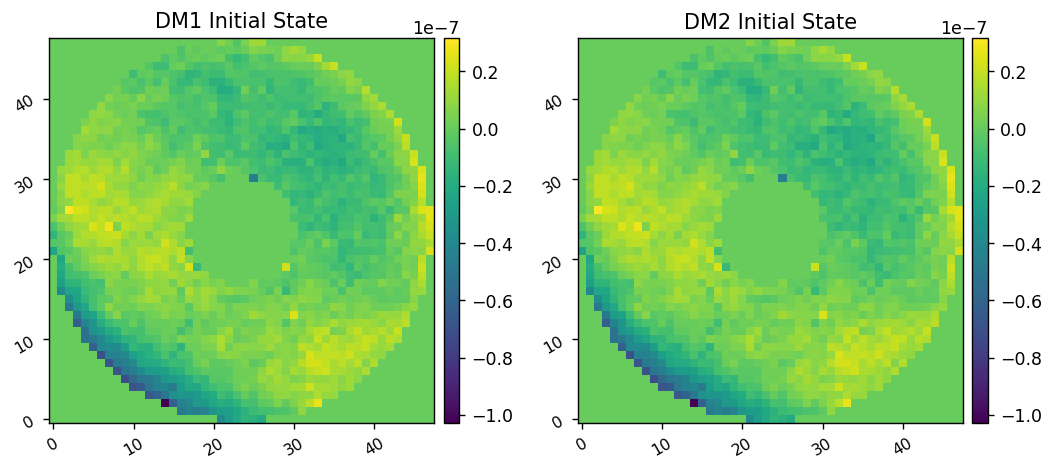

In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

imshow2(dm1_flat/2, dm2_flat/2, 'DM1 Initial State', 'DM2 Initial State', cmap1='viridis', cmap2='viridis')

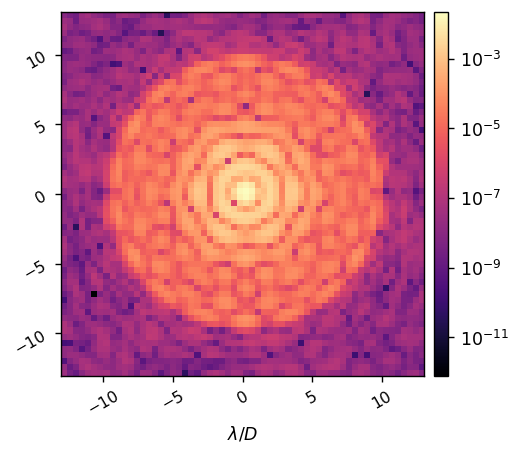

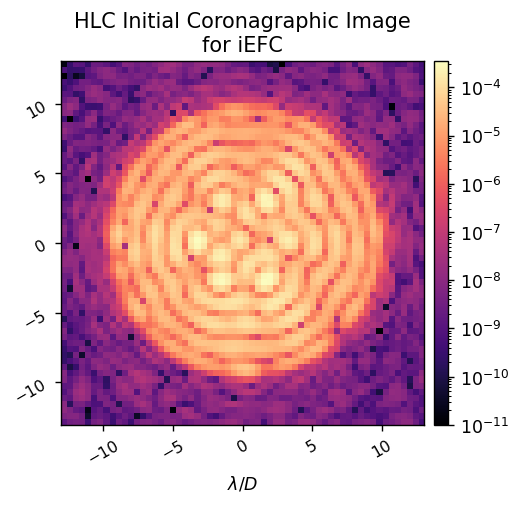

In [2]:
reload(cgi_phasec_poppy)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='hlc', npsf=60,
                                dm1_ref=dm1_flat,
                                dm2_ref=dm2_flat,
                              use_pupil_defocus=True, 
                              use_opds=True)

mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'HLC Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

# Create dark hole ROI to calibrate and control

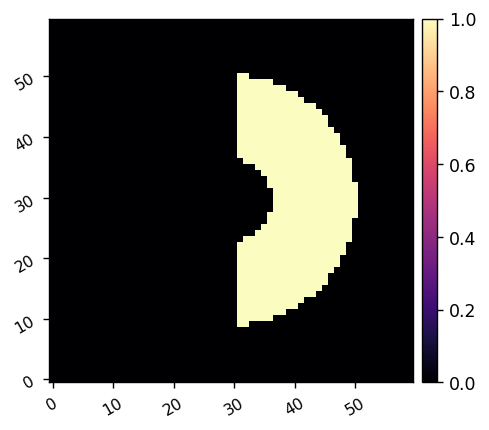

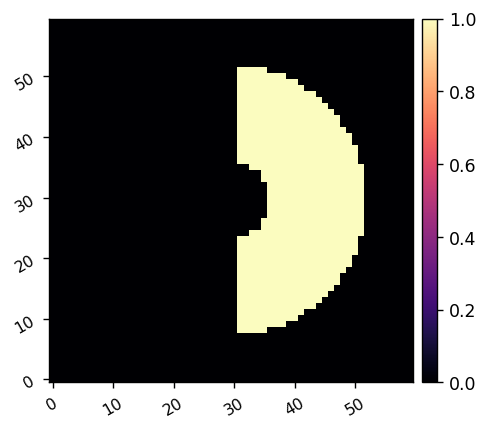

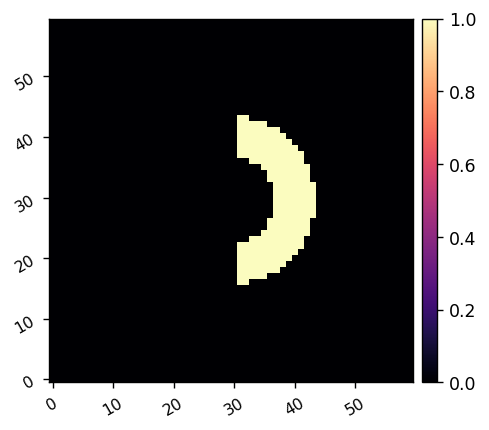

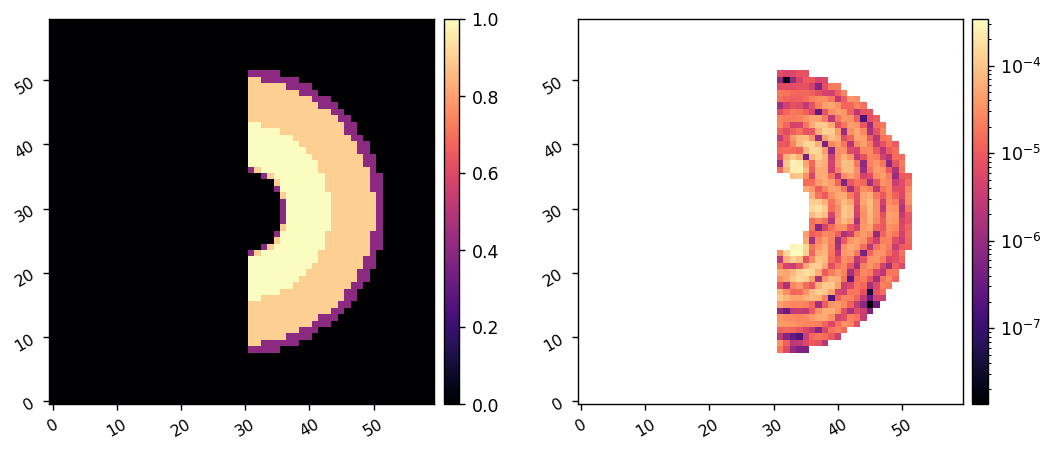

3.177583053239739e-05


In [3]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=3, outer_radius=9, edge=0.5, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=2.8, outer_radius=9.7, edge=0.5, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=3.2, outer_radius=6, edge=0.5, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create probe and fourier modes

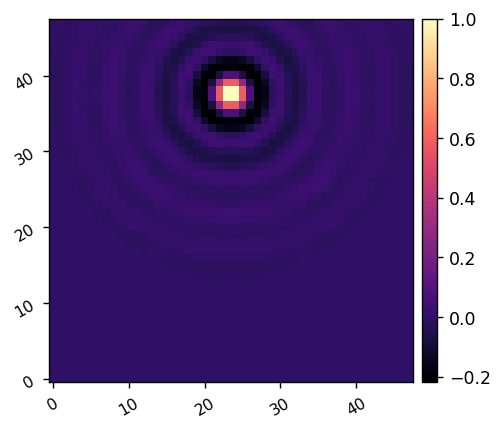

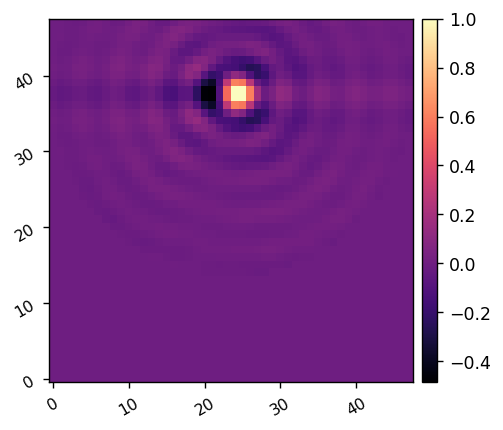

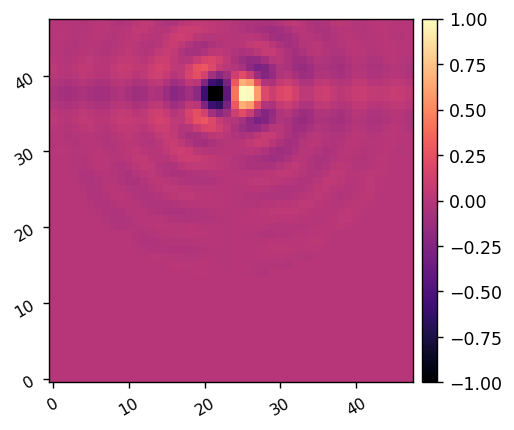

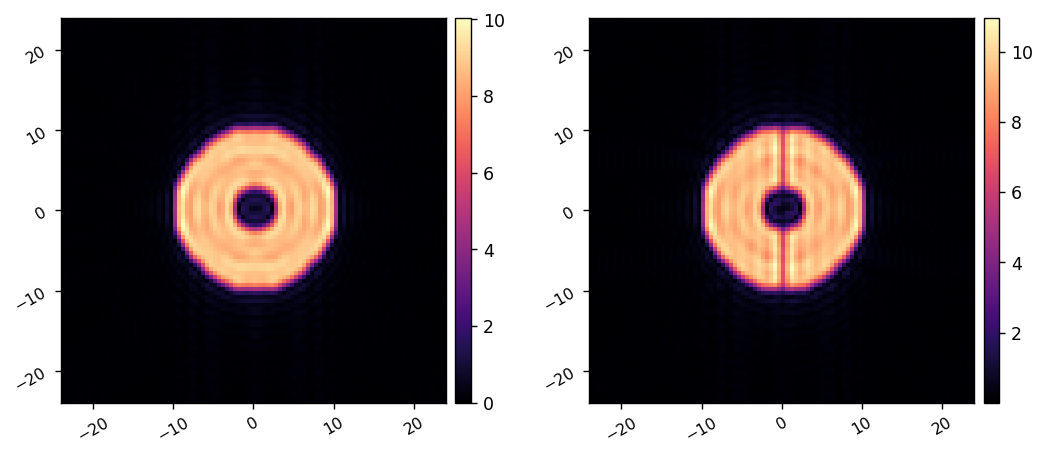

In [4]:
reload(utils)
probe_amp = 2.5e-8
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.5, shift=(0,14), nprobes=3, plot=True)

oversamp = 2
probe_1_response = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(utils.pad_or_crop(probe_modes[0], int(oversamp*mode.Nact)))))
probe_2_response = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(utils.pad_or_crop(probe_modes[1], int(oversamp*mode.Nact)))))
imshow2(abs(probe_1_response), abs(probe_2_response), pxscl=1/oversamp)

In [6]:
calib_amp = 5e-9
calib_modes = utils.create_all_poke_modes(mode.dm_mask)

# import time
# for i in range(mode.Nacts):
#     try:
#         imshow1(calib_modes[i].reshape(mode.Nact,mode.Nact))
#         clear_output(wait=True)
#         time.sleep(0.25)
#     except KeyboardInterrupt:
#         break

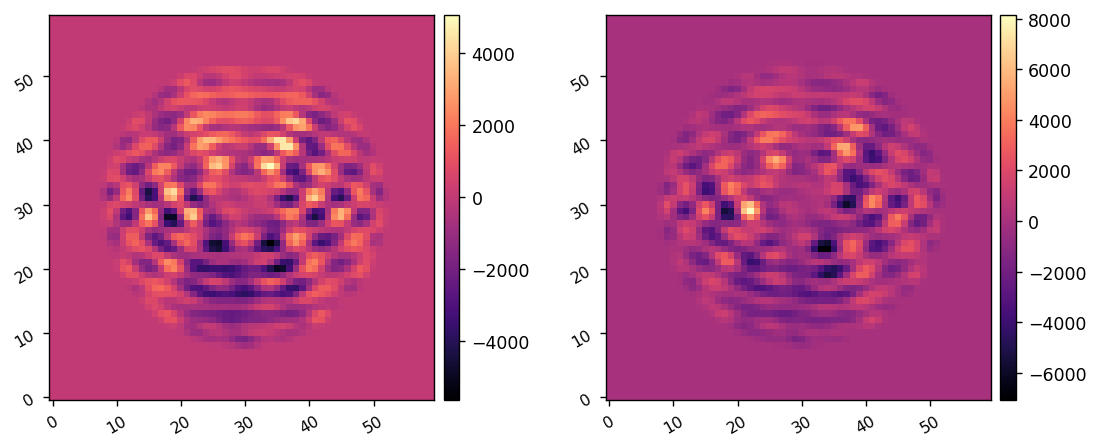

In [12]:
reload(iefc_2dm)

mode.reset_dms()

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True)
diff_ims = differential_images.reshape(len(probe_modes), mode.npsf, mode.npsf)
imshow2(diff_ims[0], diff_ims[1], wspace=0.35)

In [ ]:
reload(iefc_2dm)
response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                    calib_amp, calib_modes, 
                                                    return_all=True)


In [ ]:
utils.save_fits(response_dir/f'hlc_iefc_2dm_poke_response_matrix_{today}.fits', ensure_np_array(response_matrix))
utils.save_fits(response_dir/f'hlc_iefc_2dm_poke_response_cube_{today}.fits', ensure_np_array(response_cube))


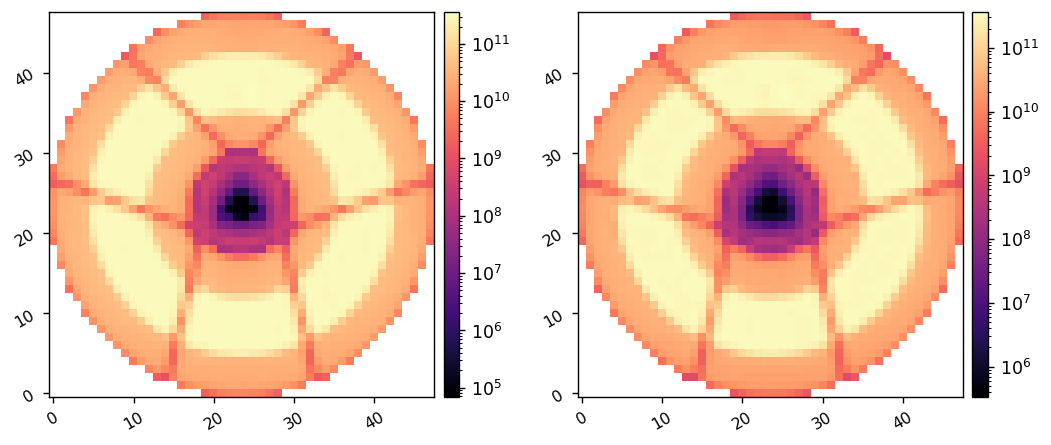

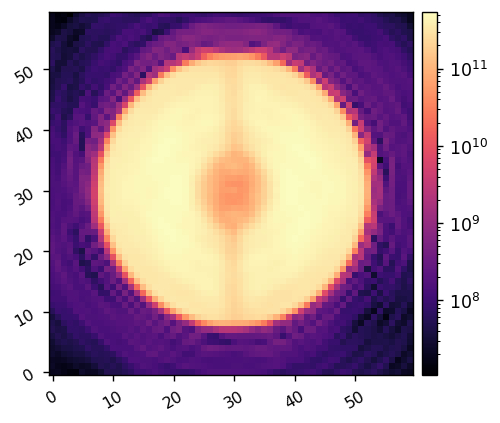

In [7]:
# date = 20230629
# date = 20230703
# date = 20230726
date = today

response_matrix = xp.array(fits.getdata(response_dir/f'hlc_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(response_dir/f'hlc_iefc_2dm_poke_response_cube_{date}.fits'))

dm1_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,:mode.Nacts]**2, axis=0)), mode.dm_mask)
dm2_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,mode.Nacts:]**2, axis=0)), mode.dm_mask)
imshow2(dm1_response , dm2_response, lognorm=True)

fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(mode.npsf, mode.npsf)
imshow1(fp_response, lognorm=True)

# Run IEFC

Running iEFC...
	Closed-loop iteration 1 / 5
	Mean NI of this iteration: 8.790e-06


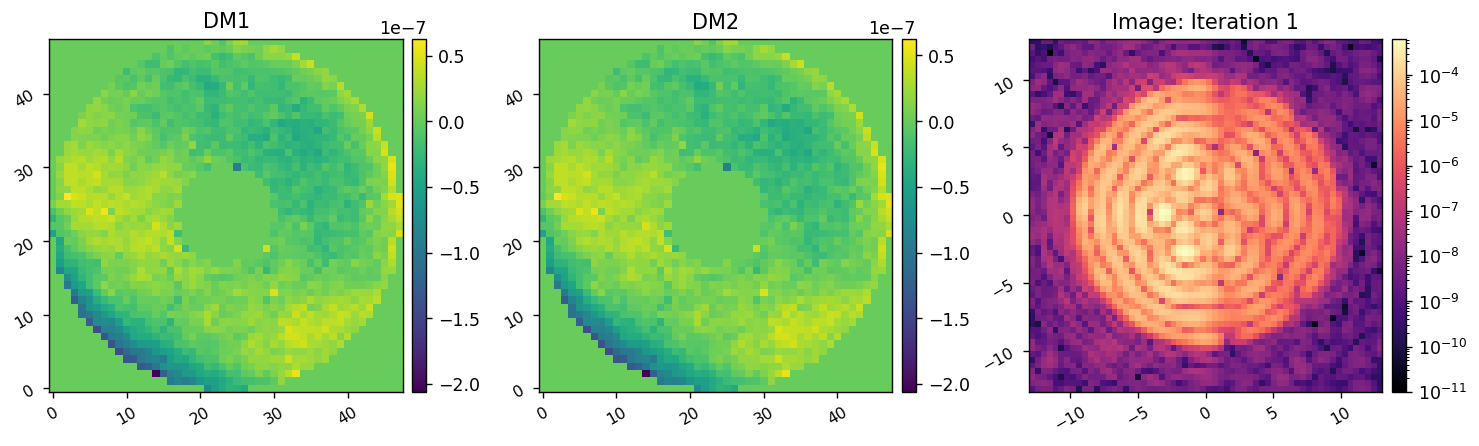

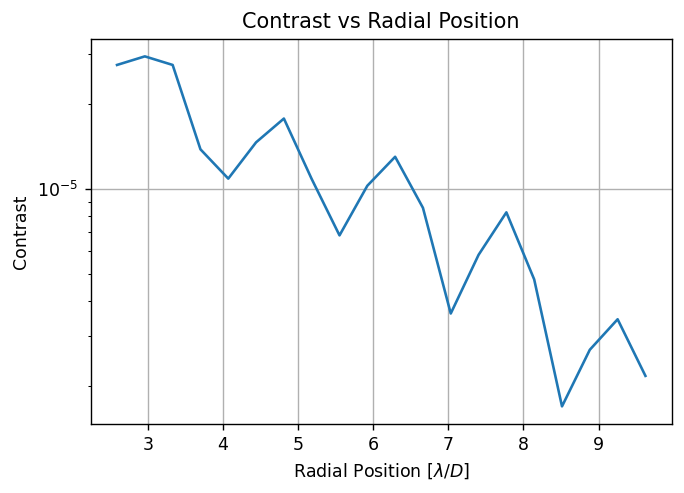

	Closed-loop iteration 2 / 5
	Mean NI of this iteration: 2.976e-06


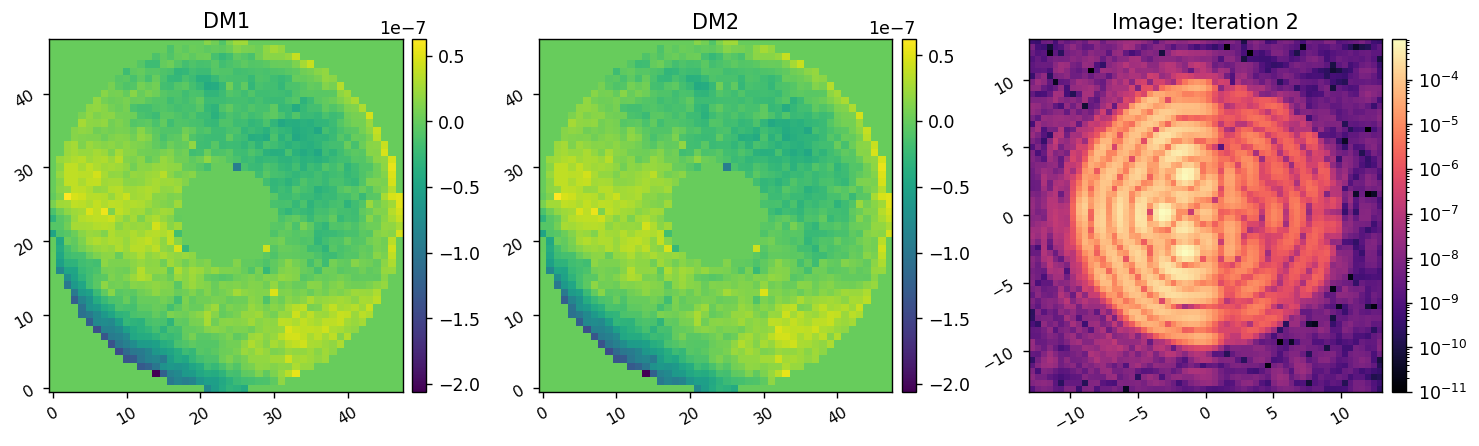

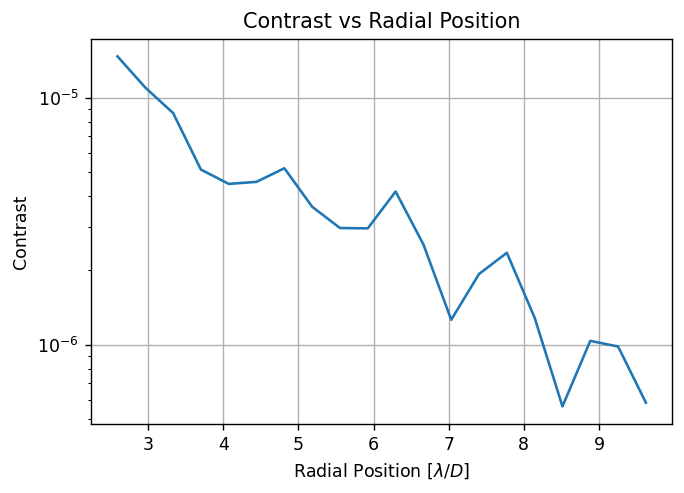

	Closed-loop iteration 3 / 5
	Mean NI of this iteration: 1.535e-06


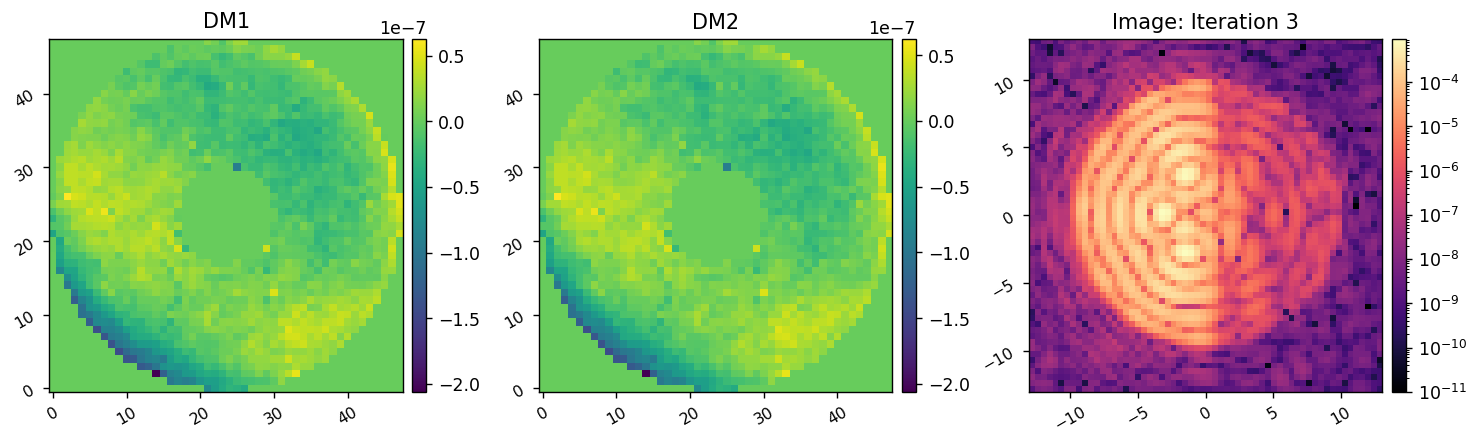

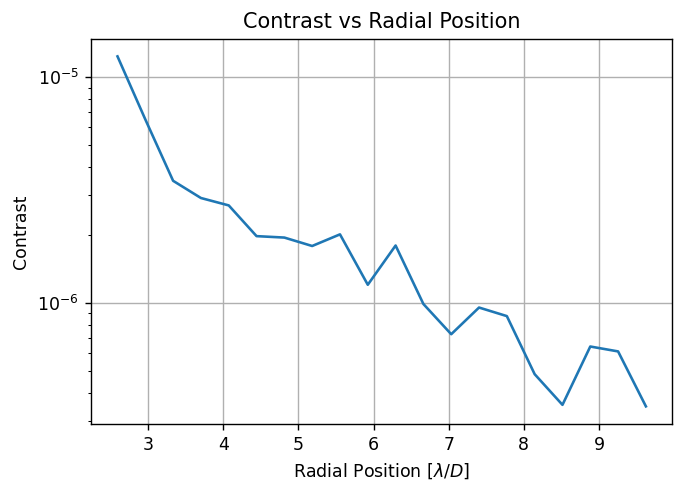

	Closed-loop iteration 4 / 5
	Mean NI of this iteration: 1.185e-06


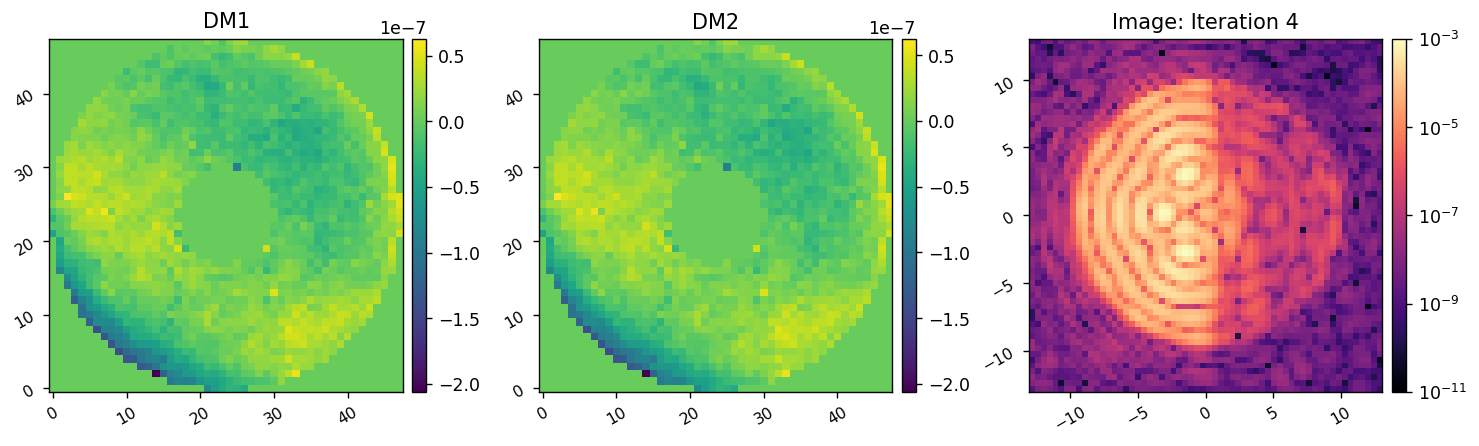

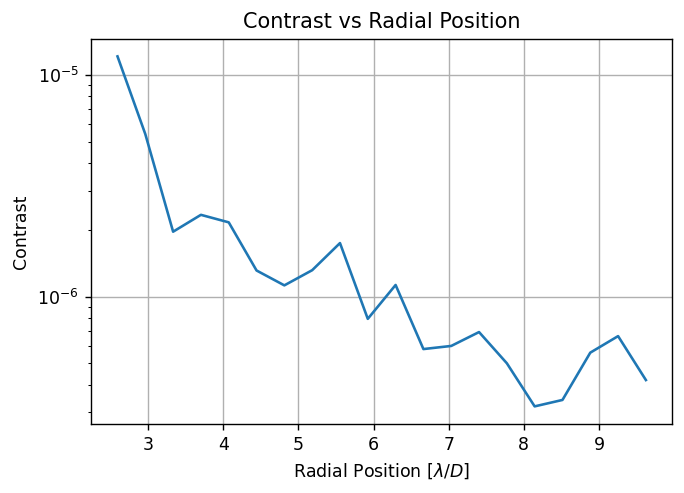

	Closed-loop iteration 5 / 5
	Mean NI of this iteration: 1.098e-06


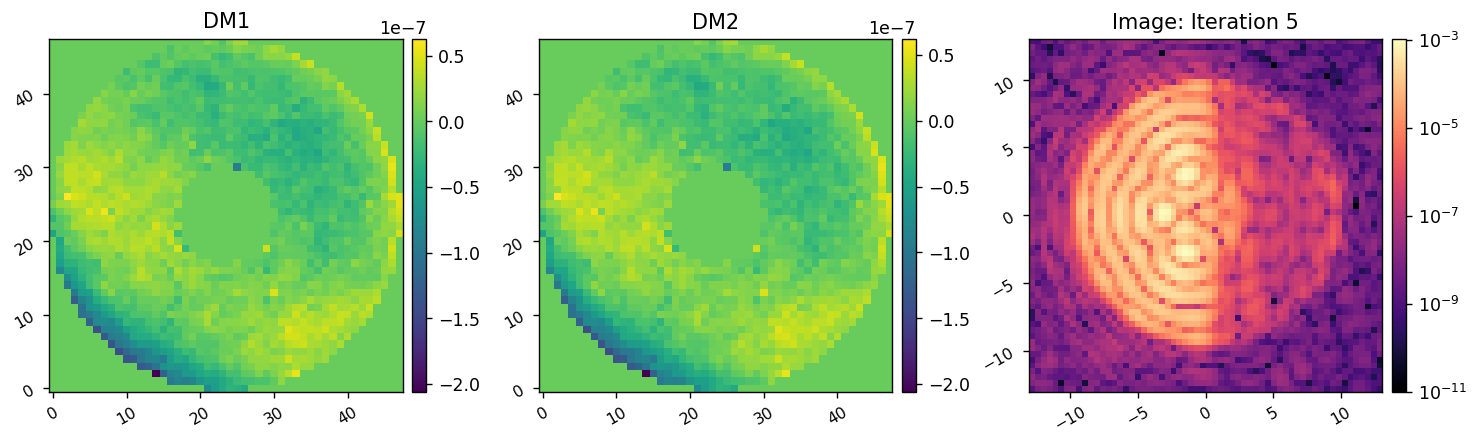

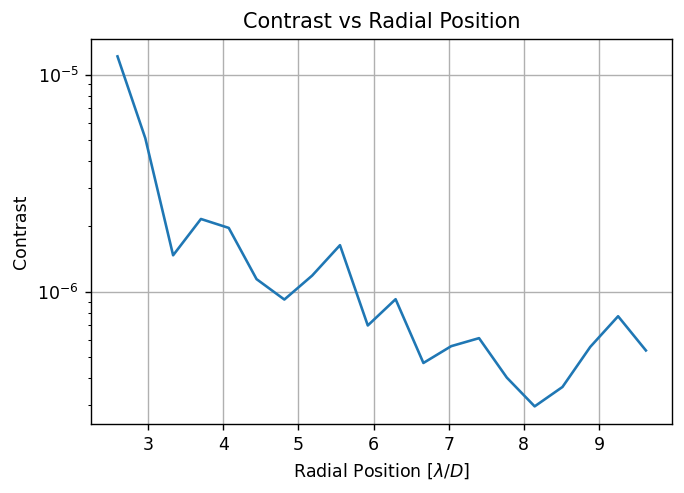

Closed loop for given control matrix completed in 14.511s.


In [11]:
reload(iefc_2dm)
reload(utils)

mode.reset_dms()

reg_cond = 1e-1
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True
                                         )

In [18]:
images.shape

(5, 60, 60)

Running iEFC...
	Closed-loop iteration 10 / 14
	Mean NI of this iteration: 6.942e-07


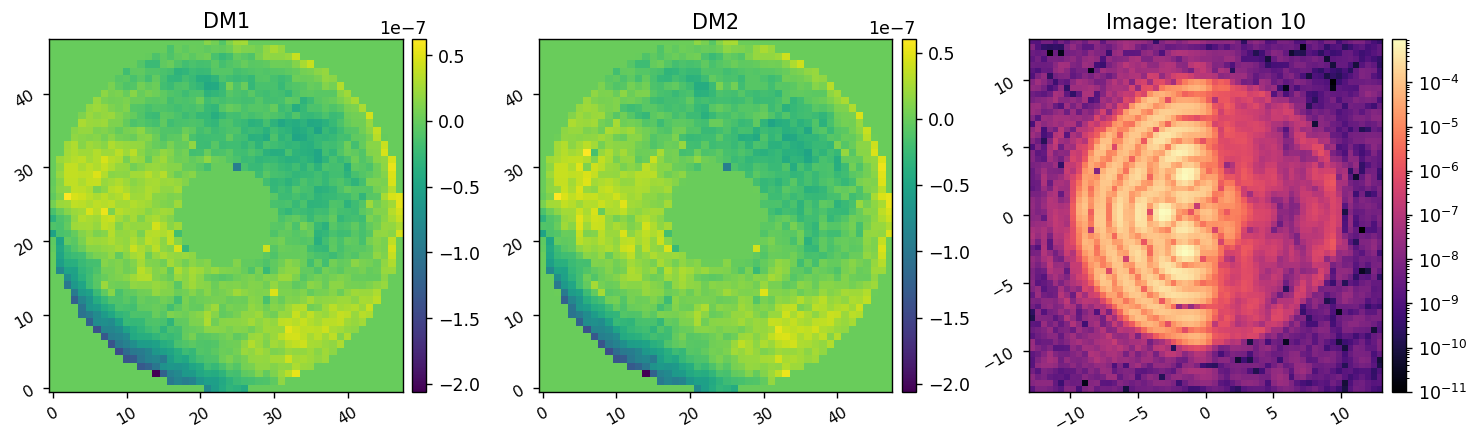

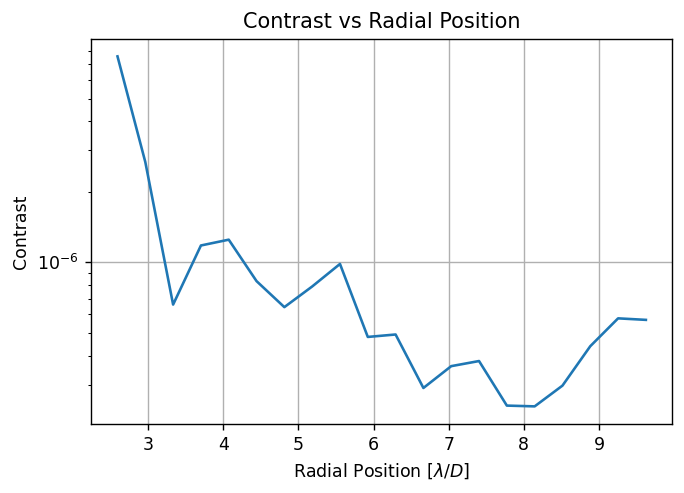

	Closed-loop iteration 11 / 14
	Mean NI of this iteration: 6.912e-07


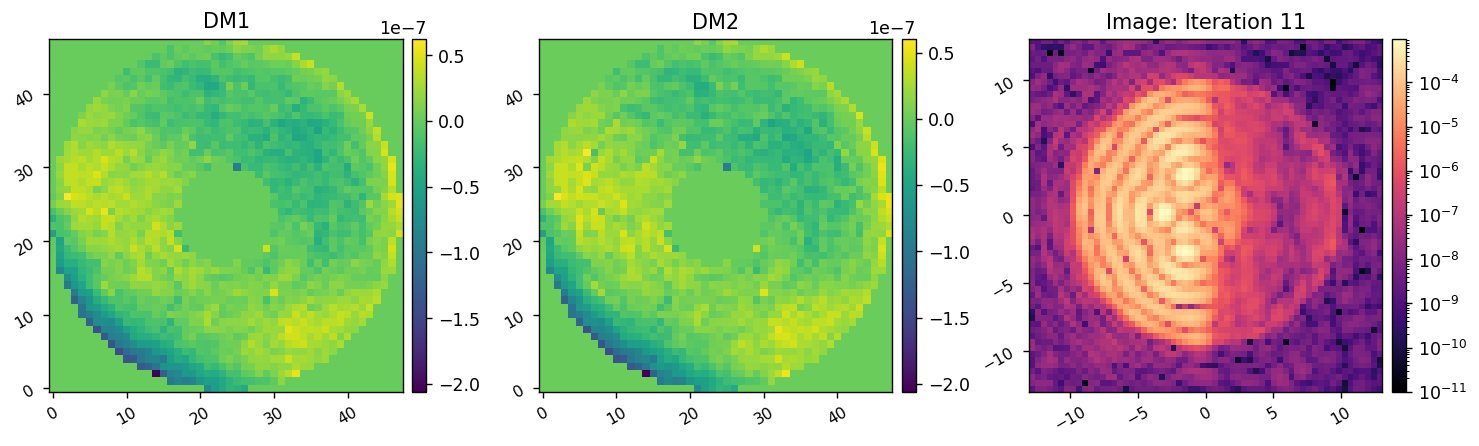

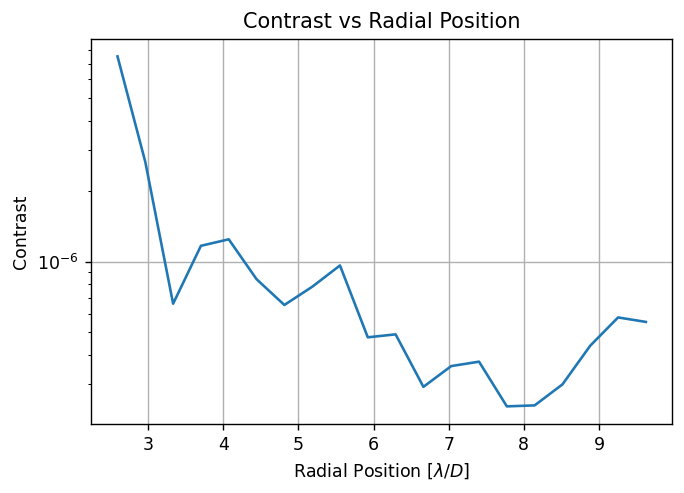

	Closed-loop iteration 12 / 14
	Mean NI of this iteration: 6.886e-07


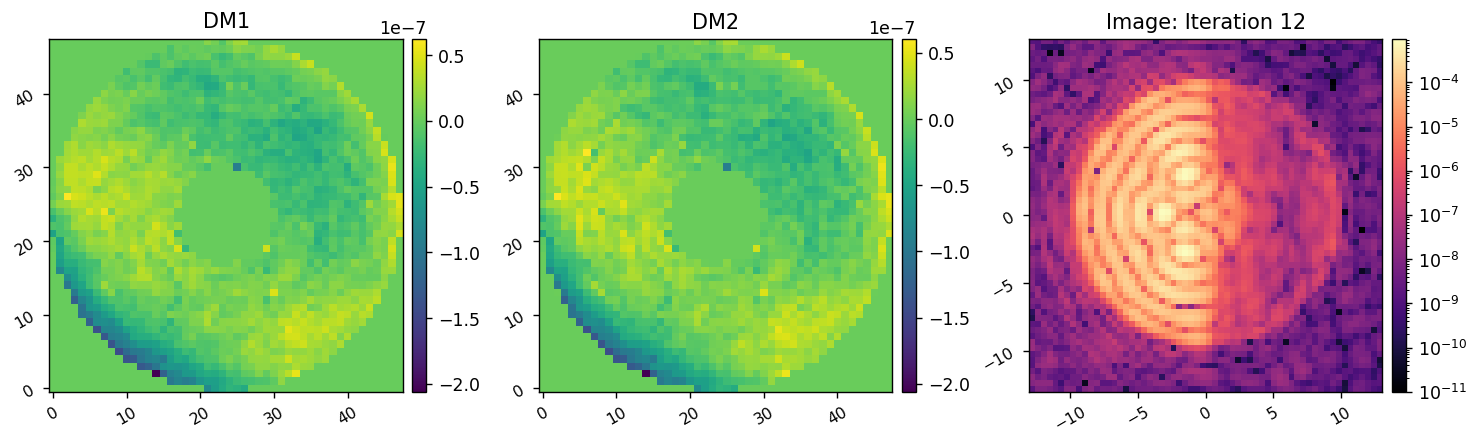

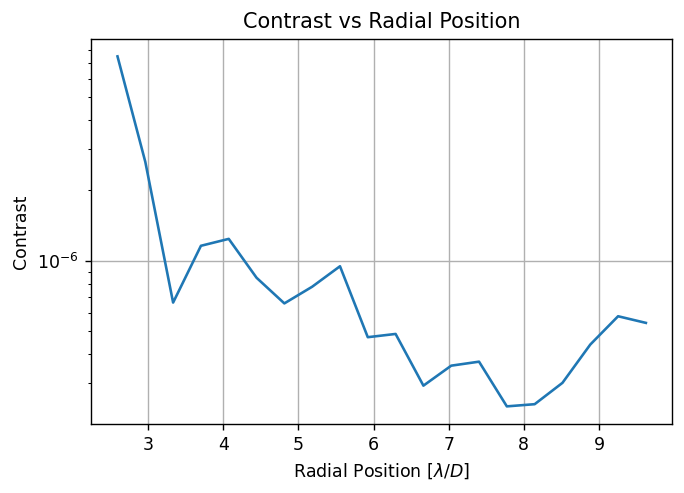

	Closed-loop iteration 13 / 14
	Mean NI of this iteration: 6.857e-07


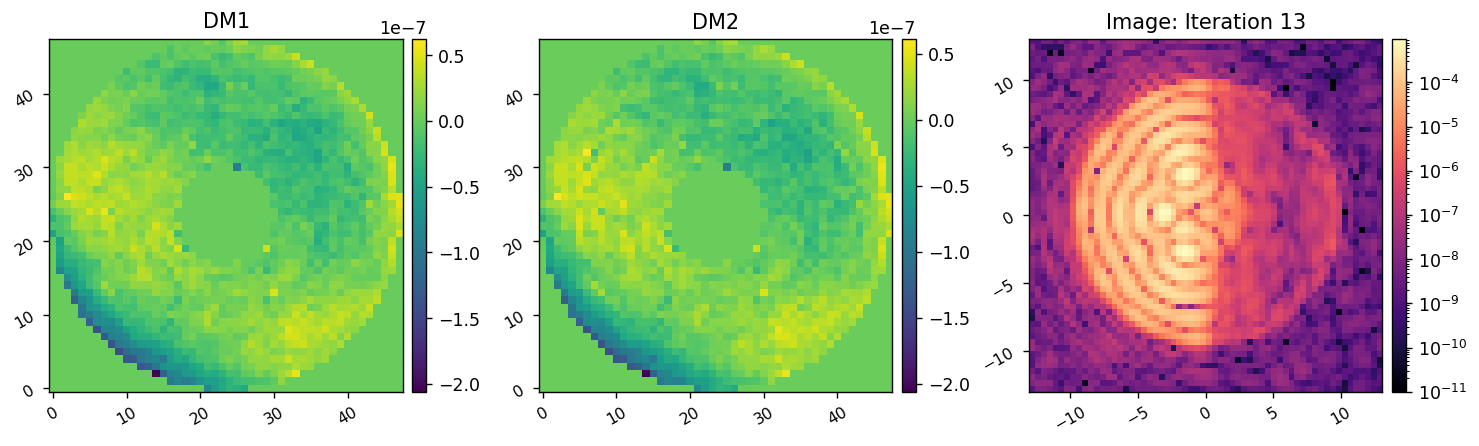

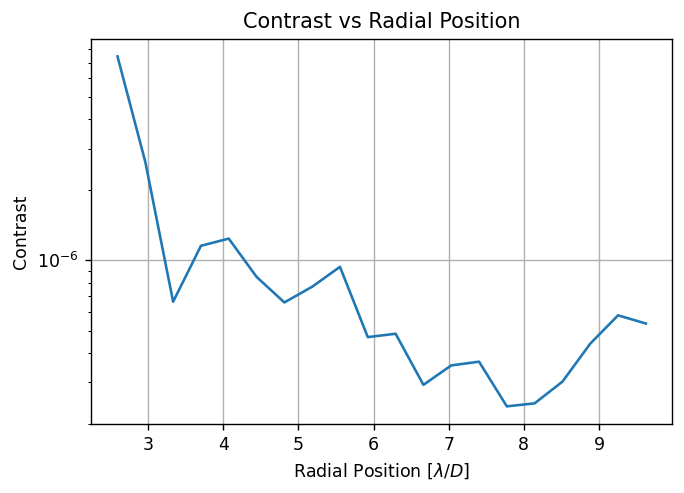

	Closed-loop iteration 14 / 14
	Mean NI of this iteration: 6.826e-07


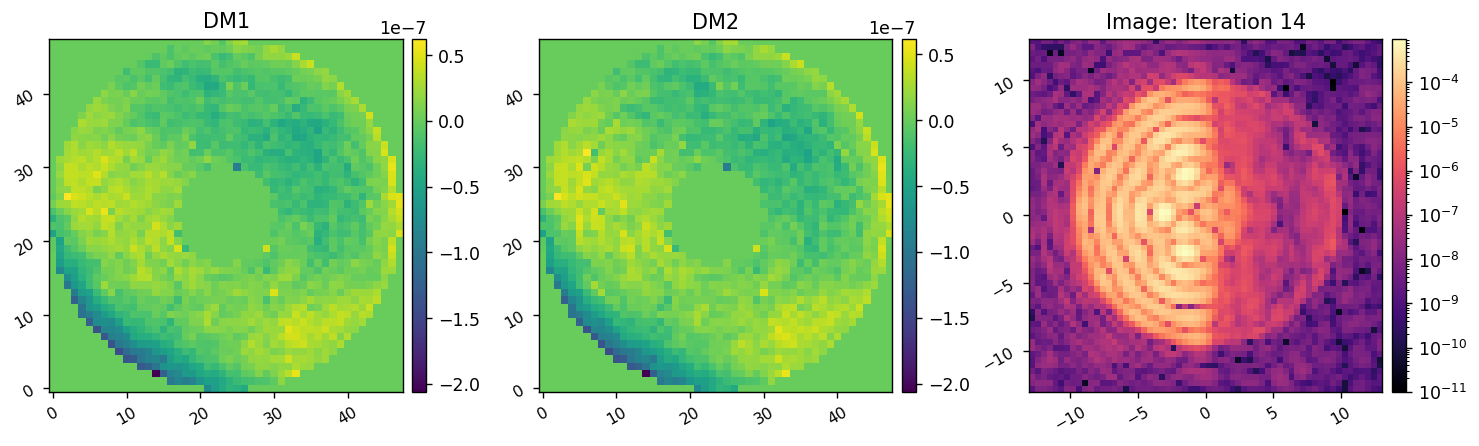

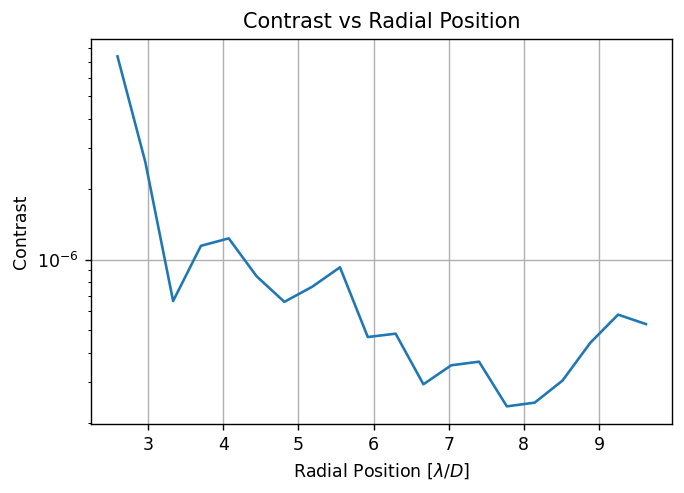

Closed loop for given control matrix completed in 14.747s.


In [13]:
reload(iefc_2dm)

Nitr = 5
reg_cond = 1e-1
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])
        
images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                                  control_matrix,
                                                  probe_modes, 
                                                  probe_amp, 
                                                  ensure_np_array(calib_modes),
                                                  control_mask, 
                                                  num_iterations=Nitr, 
#                                                   starting_iteration=0,
                                                  loop_gain=0.5, 
                                                  leakage=0,
                                                  plot_all=True,
                                                  plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                                 )